In [92]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import mediapipe as mp
from tqdm import tqdm
import cv2 as cv
import copy
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
RANDOM_SEED = 42

# Load training data

In [93]:
df = pd.read_csv('../model/keypoint_classifier/keypoint2.csv', header=None, dtype={0: str})
df.head(n = 5)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,0.0,0.0,-0.120000,0.200000,-0.400000,0.280000,-0.640000,0.280000,-0.840000,...,-1.000000,-0.160000,-0.560000,-0.480000,-0.840000,-0.440000,-0.960000,-0.320000,-1.000000,-0.200000
1,0,0.0,0.0,0.148148,0.222222,0.370370,0.333333,0.592593,0.370370,0.740741,...,0.962963,0.074074,0.629630,-0.333333,0.888889,-0.222222,0.962963,-0.074074,1.000000,0.000000
2,0,0.0,0.0,-0.200000,0.120000,-0.440000,0.160000,-0.680000,0.160000,-0.880000,...,-1.000000,-0.320000,-0.400000,-0.600000,-0.680000,-0.600000,-0.880000,-0.480000,-0.960000,-0.400000
3,0,0.0,0.0,0.208333,-0.125000,0.416667,-0.250000,0.583333,-0.375000,0.750000,...,0.958333,-0.333333,0.291667,-0.458333,0.541667,-0.458333,0.750000,-0.375000,0.875000,-0.333333
4,0,0.0,0.0,0.166667,0.333333,0.666667,0.333333,0.833333,0.166667,1.000000,...,0.500000,-0.166667,0.166667,-0.500000,0.500000,-0.500000,0.500000,-0.333333,0.333333,-0.333333


In [94]:
label_counts = df[0].value_counts().sort_index()
print(label_counts)

0
0    2528
1    4089
2    4151
3    5963
4    6621
5    9504
6    4181
7    5773
8    5840
9    6000
A    5100
B    8862
C    8564
D    8862
E     379
F    8904
G    8850
H    8880
I    8526
J    6942
K    8394
L    8876
M     322
N    7625
O     624
P    8817
Q    8837
R    8865
S     438
T    2189
U    8876
V    8899
W    8776
X    8852
Y     754
Z    7618
_    4421
Name: count, dtype: int64


In [95]:
# Separate features and labels
X = df.iloc[:, 1:]  # 42 landmark features
y = df.iloc[:, 0]   # labels

# Create VarianceThreshold filter
# threshold=0 removes only features with **zero** variance (same value in all rows)
# Try threshold=0.01 or 0.001 to remove near-constant features
selector = VarianceThreshold(threshold=0.001)

# Fit and transform
X_selected = selector.fit_transform(X)

# Get kept feature indices (optional)
selected_features = X.columns[selector.get_support(indices=True)]

print(f"Original features: {X.shape[1]}")
print(f"Selected features: {X_selected.shape[1]}")
print("Remaining features:", list(selected_features))

# Combine with labels again (if needed)
df_filtered = pd.concat([y.reset_index(drop=True), pd.DataFrame(X_selected)], axis=1)

Original features: 42
Selected features: 40
Remaining features: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


### Class Distribution Plot

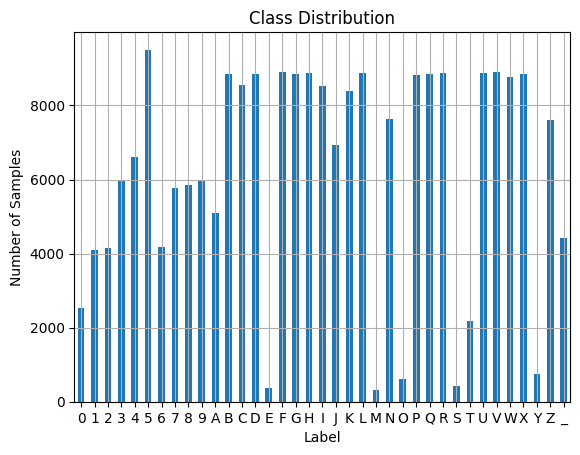

In [96]:
label_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

### Feature Value Range (Histogram/Boxplot)

This graph shows 42 histograms, one for each feature in your landmark dataset (21 keypoints × x and y values).
    - Feature 1 → x-coordinate of landmark 0
    - Feature 2 → y-coordinate of landmark 0
    - ...
    - Feature 41–42 → x and y of landmark 20

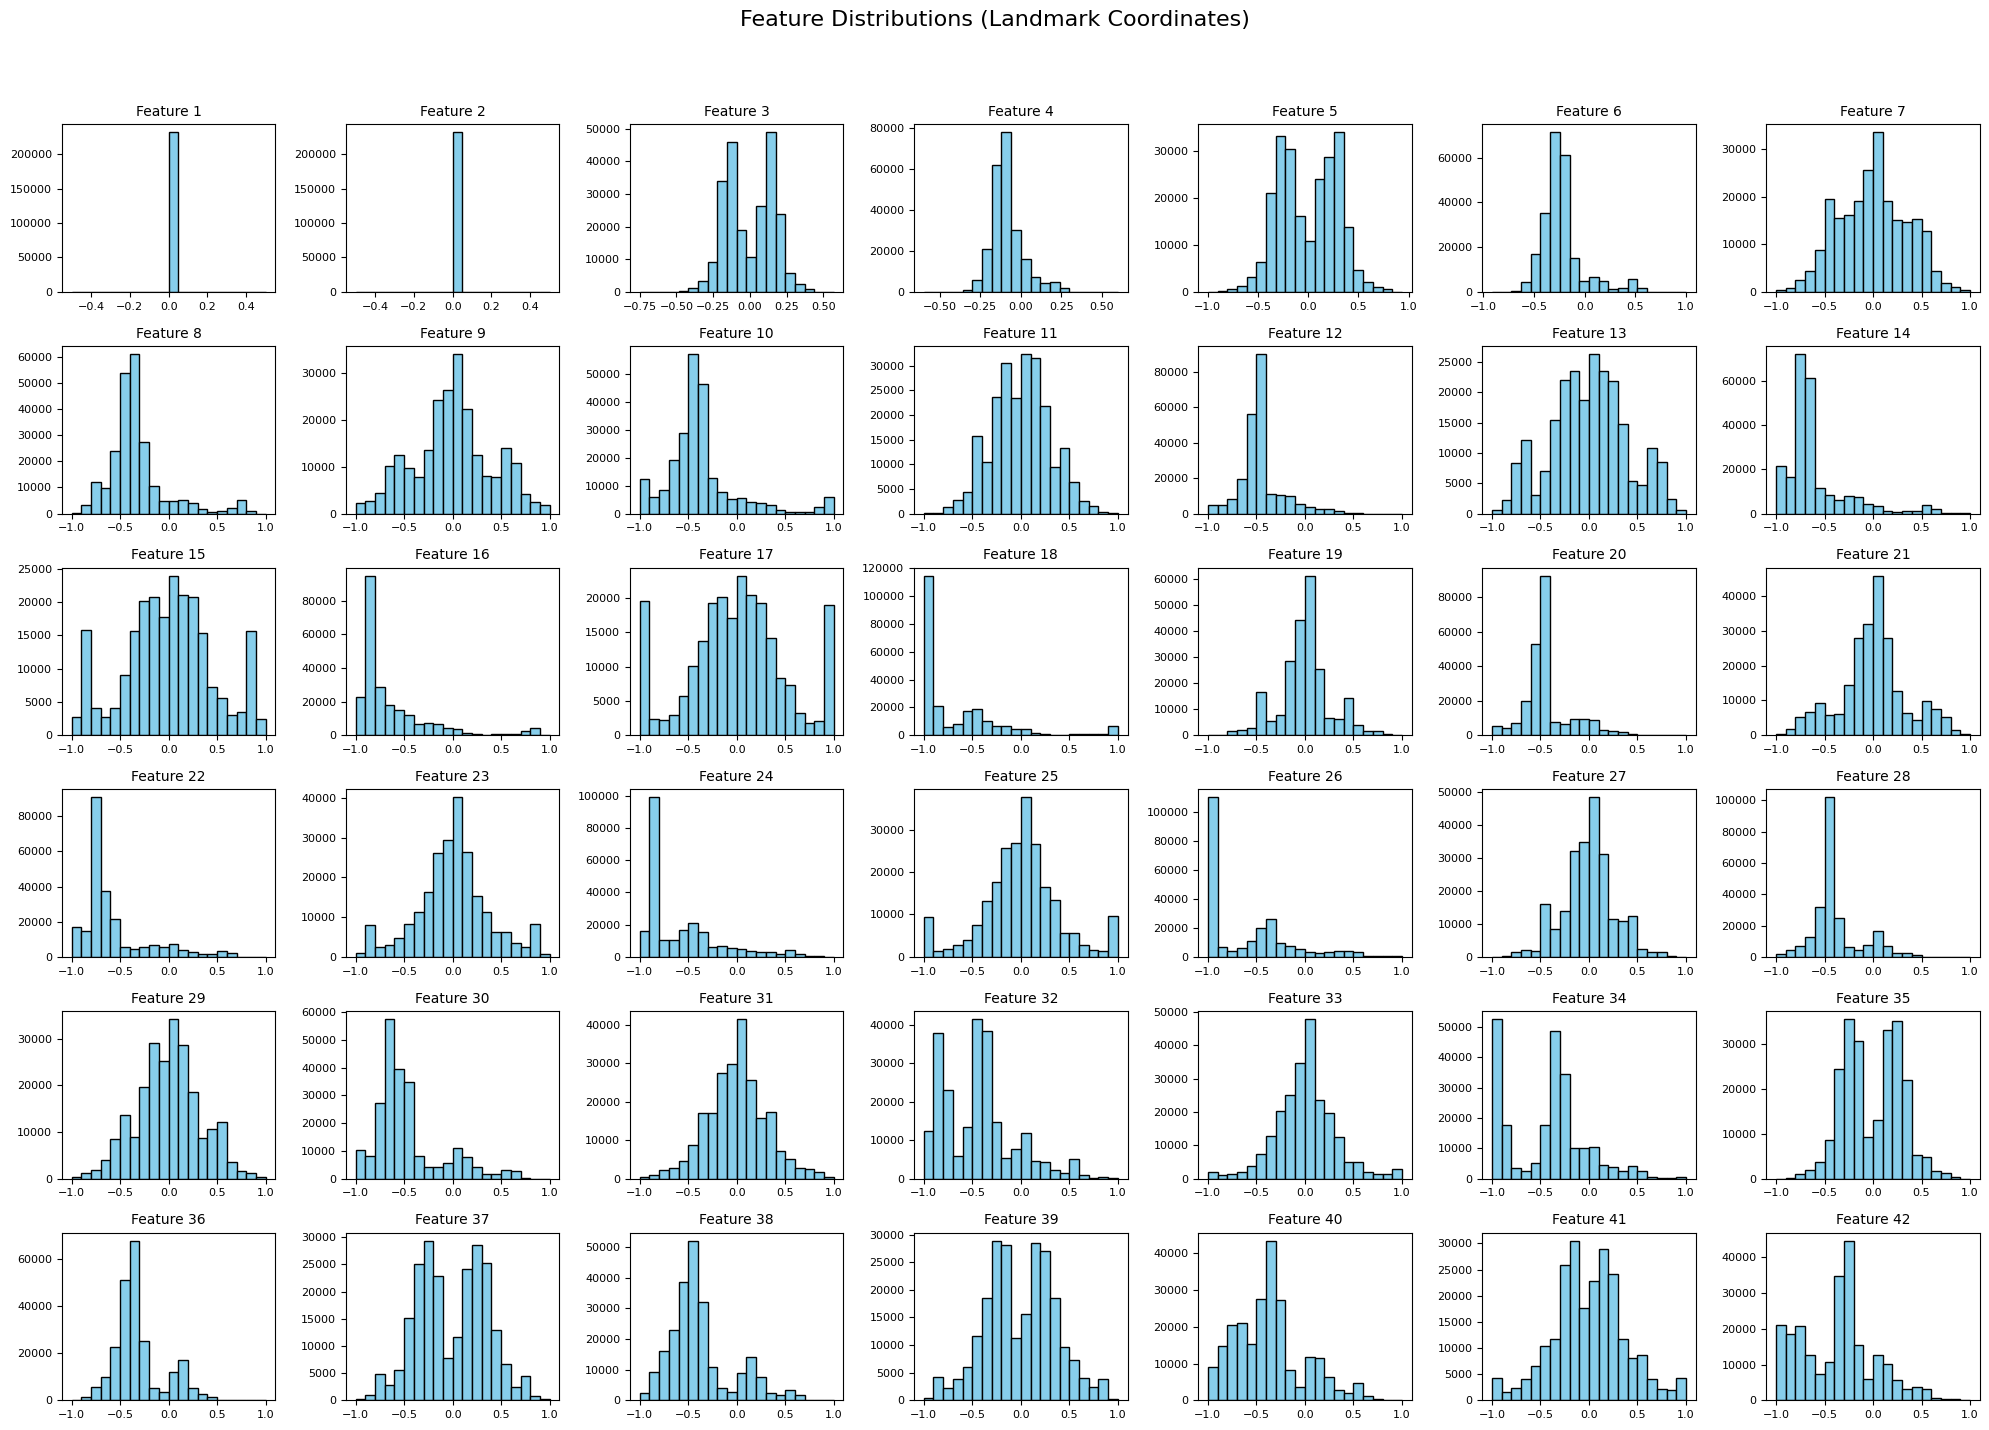

In [97]:
fig, axes = plt.subplots(6, 7, figsize=(20, 15))  # 6 rows × 7 cols
fig.suptitle("Feature Distributions (Landmark Coordinates)", fontsize=16)

for i in range(42):
    row = i // 7
    col = i % 7
    ax = axes[row, col]
    ax.hist(df[i + 1], bins=20, color='skyblue', edgecolor='black')  # +1 because column 0 is label
    ax.set_title(f'Feature {i+1}', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
plt.show()

### Mean Hand Shape by Class (Heatmap)
Each dot in a subplot is the average position of one of the 21 hand landmarks (e.g., fingertips, joints, wrist), computed across all samples of that label.

- **X-axis:** average horizontal (left/right) position
- **Y-axis:** average vertical (up/down) position (flipped for camera-like view)

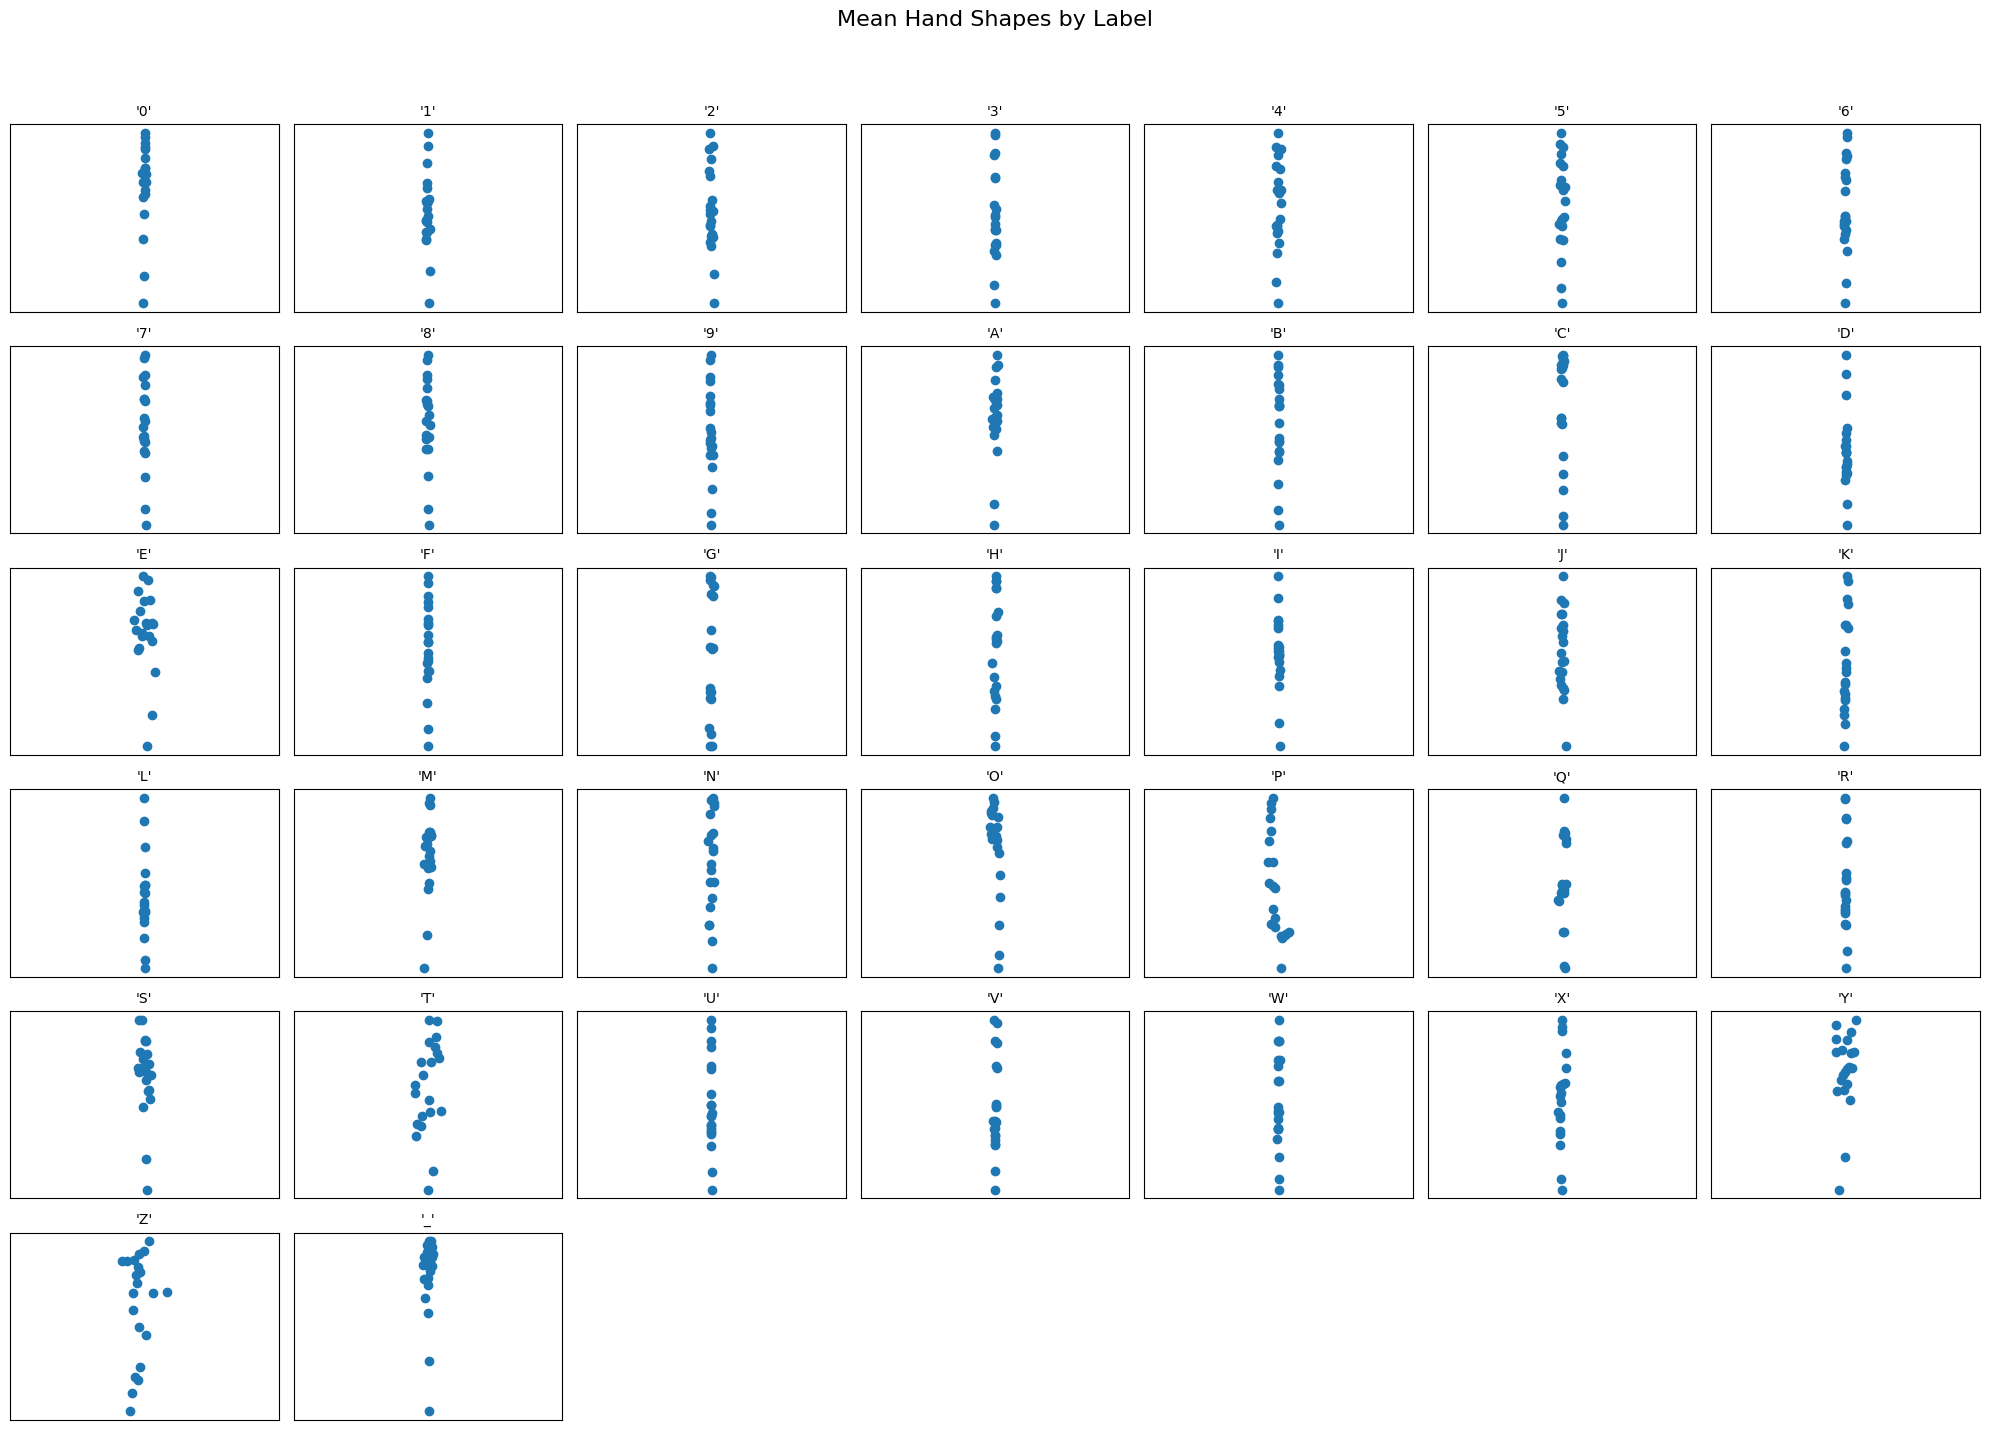

In [98]:
import matplotlib.pyplot as plt
import numpy as np

unique_labels = sorted(df[0].unique())  # Ensure consistent ordering
fig, axes = plt.subplots(6, 7, figsize=(20, 15))
fig.suptitle("Mean Hand Shapes by Label", fontsize=16)

for idx, label in enumerate(unique_labels): # 37 labels
    row = idx // 7
    col = idx % 7
    ax = axes[row, col]

    subset = df[df[0] == label].iloc[:, 1:].values # filter rows by label and get the 42 features
    mean = np.mean(subset, axis=0) # compute the mean of the 42 features across all samples of that label
    x = mean[::2] 
    y = mean[1::2]

    ax.scatter(x, -y)  # Flip y for intuitive camera view
    ax.set_title(f"'{label}'", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')

# Hide any unused subplots
for idx in range(len(unique_labels), 6 * 7):
    fig.delaxes(axes[idx // 7, idx % 7])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### t-SNE or PCA (Dimensionality Reduction Visualization)

t-SNE projection of your hand gesture dataset in 2D. 

- Each point = a sample
- Each color = a class (gesture label 0–35)

In [99]:
X = df.iloc[:, 1:].values # all rows of all columns except the first one
y = df[0].values

X_embedded = TSNE(n_components=2).fit_transform(X)

In [100]:
len(pd.DataFrame(y).value_counts())

37

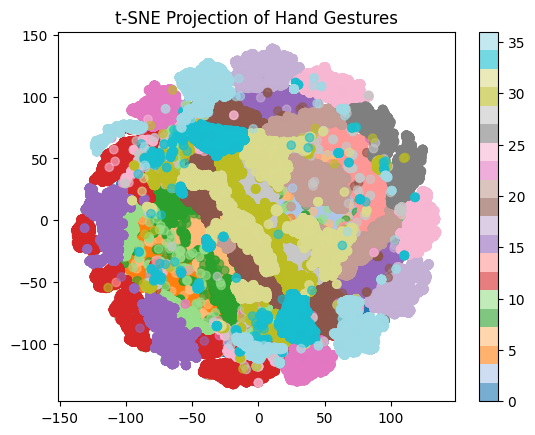

In [101]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=pd.factorize(y)[0], cmap='tab20', alpha=0.6)
plt.title("t-SNE Projection of Hand Gestures")
plt.colorbar()
plt.show()

### Model training

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [124]:
# Combine back into a filtered DataFrame
df_filtered = pd.concat([pd.DataFrame(y).reset_index(drop=True), pd.DataFrame(X_selected)], axis=1)
df_filtered

,0,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,0,-0.120000,0.200000,-0.400000,0.280000,-0.640000,0.280000,-0.840000,0.280000,-0.400000,...,-1.000000,-0.160000,-0.560000,-0.480000,-0.840000,-0.440000,-0.960000,-0.320000,-1.000000,-0.200000
1,0,0.148148,0.222222,0.370370,0.333333,0.592593,0.370370,0.740741,0.370370,0.444444,...,0.962963,0.074074,0.629630,-0.333333,0.888889,-0.222222,0.962963,-0.074074,1.000000,0.000000
2,0,-0.200000,0.120000,-0.440000,0.160000,-0.680000,0.160000,-0.880000,0.120000,-0.360000,...,-1.000000,-0.320000,-0.400000,-0.600000,-0.680000,-0.600000,-0.880000,-0.480000,-0.960000,-0.400000
3,0,0.208333,-0.125000,0.416667,-0.250000,0.583333,-0.375000,0.750000,-0.458333,0.333333,...,0.958333,-0.333333,0.291667,-0.458333,0.541667,-0.458333,0.750000,-0.375000,0.875000,-0.333333
4,0,0.166667,0.333333,0.666667,0.333333,0.833333,0.166667,1.000000,0.166667,0.666667,...,0.500000,-0.166667,0.166667,-0.500000,0.500000,-0.500000,0.500000,-0.333333,0.333333,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231697,_,0.300000,-0.300000,0.600000,-0.400000,0.800000,-0.300000,1.000000,-0.300000,0.700000,...,0.400000,0.000000,0.400000,0.300000,0.500000,0.200000,0.400000,0.100000,0.300000,0.100000
231698,_,-0.300000,-0.200000,-0.600000,-0.300000,-0.800000,-0.300000,-1.000000,-0.300000,-0.700000,...,-0.700000,0.000000,-0.400000,0.200000,-0.500000,0.200000,-0.500000,0.200000,-0.500000,0.200000
231699,_,0.139535,-0.232558,0.116279,-0.418605,0.116279,-0.511628,0.116279,-0.604651,-0.186047,...,0.627907,-1.000000,-0.069767,-0.697674,0.232558,-0.813953,0.418605,-0.906977,0.558140,-0.976744
231700,_,-0.170732,-0.243902,-0.146341,-0.463415,-0.121951,-0.585366,-0.121951,-0.682927,0.170732,...,-0.634146,-1.000000,0.048780,-0.682927,-0.243902,-0.829268,-0.439024,-0.902439,-0.585366,-0.975610


#### Encode labels and split the dataset

In [125]:
# Features and labels
X = df_filtered.iloc[:, 1:].values.astype('float32')  # shape: (n_samples, 40)
y = df_filtered.iloc[:, 0].values                     # shape: (n_samples,)

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("y_encoded:", y_encoded)

# One-hot encode for classification
y_categorical = to_categorical(y_encoded)
print("y_categorical:", y_categorical)


num_classes = y_categorical.shape[1]
input_shape = X.shape[1]
print(f"Number of classes: {num_classes}")
print(f"Input shape: {input_shape}")

y_encoded: [ 0  0  0 ... 36 36 36]
y_categorical: [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Number of classes: 37
Input shape: 40


In [126]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)

#stratify: Each class appears in similar proportions in both training and test sets

In [127]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Output = number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/home/thong/Desktop/hand-gesture-detection/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 37)             │         2,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,909 (62.14 KB)

 Trainable params: 15,909 (62.14 KB)

 Non-trainable params: 0 (0.00 B)

### 1. ModelCheckpoint
- Automatically saves your model to disk during training.

- You can specify to save:
    - After every epoch
    - Only the best model (based on validation loss or accuracy)

### 2. EarlyStopping

- Stops training early if the validation performance stops improving. Prevents overfitting and saves time.

In [128]:
model_save_path = '../model/keypoint_classifier/keypoint_classifier.h5'

checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_accuracy',   
    save_best_only=True,
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,        # Wait 5 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=30,
    verbose=1,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/30
5741/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.6084 - loss: 1.4350
Epoch 1: val_accuracy improved from -inf to 0.91373, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 967us/step - accuracy: 0.6099 - loss: 1.4299 - val_accuracy: 0.9137 - val_loss: 0.3330
Epoch 2/30
5773/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.8804 - loss: 0.4581
Epoch 2: val_accuracy improved from 0.91373 to 0.92734, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 964us/step - accuracy: 0.8805 - loss: 0.4580 - val_accuracy: 0.9273 - val_loss: 0.2630
Epoch 3/30
5775/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9034 - loss: 0.3746
Epoch 3: val_accuracy improved from 0.92734 to 0.93859, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 955us/step - accuracy: 0.9034 - loss: 0.3745 - val_accuracy: 0.9386 - val_loss: 0.2251
Epoch 4/30
5764/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.9143 - loss: 0.3253
Epoch 4: val_accuracy improved from 0.93859 to 0.94092, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 963us/step - accuracy: 0.9143 - loss: 0.3253 - val_accuracy: 0.9409 - val_loss: 0.2128
Epoch 5/30
5782/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.9180 - loss: 0.3135
Epoch 5: val_accuracy improved from 0.94092 to 0.94461, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 960us/step - accuracy: 0.9181 - loss: 0.3135 - val_accuracy: 0.9446 - val_loss: 0.1997
Epoch 6/30
5775/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.9227 - loss: 0.2932
Epoch 6: val_accuracy improved from 0.94461 to 0.94733, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 971us/step - accuracy: 0.9227 - loss: 0.2932 - val_accuracy: 0.9473 - val_loss: 0.1878
Epoch 7/30
5741/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.9239 - loss: 0.2847
Epoch 7: val_accuracy improved from 0.94733 to 0.94912, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 981us/step - accuracy: 0.9240 - loss: 0.2846 - val_accuracy: 0.9491 - val_loss: 0.1818
Epoch 8/30
5786/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.9268 - loss: 0.2748
Epoch 8: val_accuracy did not improve from 0.94912
5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 963us/step - accuracy: 0.9268 - loss: 0.2748 - val_accuracy: 0.9483 - val_loss: 0.1791
Epoch 9/30
5735/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.9288 - loss: 0.2634
Epoch 9: val_accuracy did not improve from 0.94912
5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 972us/step - accuracy: 0.9288 - loss: 0.2635 - val_accuracy: 0.9491 - val_loss: 0.1790
Epoch 10/30
5773/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.9293 - loss: 0.2646
Epoch 10: val_accuracy did not improve from 0.94912
5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 977us/step - accuracy: 0.9293 - loss: 0.2646 - val_accuracy: 0.9482 - val_loss: 0.1747
Epoch 11/30
5775/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.9312 - loss: 0.2568


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9312 - loss: 0.2568 - val_accuracy: 0.9515 - val_loss: 0.1676
Epoch 12/30
5770/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.9325 - loss: 0.2503
Epoch 12: val_accuracy improved from 0.95149 to 0.95153, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9325 - loss: 0.2503 - val_accuracy: 0.9515 - val_loss: 0.1712
Epoch 13/30
5773/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.9327 - loss: 0.2460
Epoch 13: val_accuracy improved from 0.95153 to 0.95348, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9327 - loss: 0.2460 - val_accuracy: 0.9535 - val_loss: 0.1623
Epoch 14/30
5757/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.9334 - loss: 0.2423
Epoch 14: val_accuracy did not improve from 0.95348
5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9334 - loss: 0.2423 - val_accuracy: 0.9518 - val_loss: 0.1649
Epoch 15/30
5777/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.9342 - loss: 0.2394
Epoch 15: val_accuracy improved from 0.95348 to 0.95389, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 980us/step - accuracy: 0.9342 - loss: 0.2394 - val_accuracy: 0.9539 - val_loss: 0.1608
Epoch 16/30
5751/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.9332 - loss: 0.2427
Epoch 16: val_accuracy improved from 0.95389 to 0.95438, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9332 - loss: 0.2427 - val_accuracy: 0.9544 - val_loss: 0.1569
Epoch 17/30
5758/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9357 - loss: 0.2350
Epoch 17: val_accuracy did not improve from 0.95438
5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 991us/step - accuracy: 0.9357 - loss: 0.2350 - val_accuracy: 0.9543 - val_loss: 0.1588
Epoch 18/30
5770/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.9357 - loss: 0.2341
Epoch 18: val_accuracy improved from 0.95438 to 0.95455, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 977us/step - accuracy: 0.9357 - loss: 0.2341 - val_accuracy: 0.9546 - val_loss: 0.1573
Epoch 19/30
5738/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.9372 - loss: 0.2304
Epoch 19: val_accuracy did not improve from 0.95455
5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 990us/step - accuracy: 0.9372 - loss: 0.2304 - val_accuracy: 0.9535 - val_loss: 0.1580
Epoch 20/30
5789/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.9375 - loss: 0.2313
Epoch 20: val_accuracy improved from 0.95455 to 0.95512, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9375 - loss: 0.2313 - val_accuracy: 0.9551 - val_loss: 0.1540
Epoch 21/30
5783/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.9367 - loss: 0.2326
Epoch 21: val_accuracy improved from 0.95512 to 0.95529, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9367 - loss: 0.2326 - val_accuracy: 0.9553 - val_loss: 0.1543
Epoch 22/30
5765/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.9384 - loss: 0.2248
Epoch 22: val_accuracy improved from 0.95529 to 0.95568, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9384 - loss: 0.2248 - val_accuracy: 0.9557 - val_loss: 0.1517
Epoch 23/30
5763/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9386 - loss: 0.2217
Epoch 23: val_accuracy did not improve from 0.95568
5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9386 - loss: 0.2217 - val_accuracy: 0.9552 - val_loss: 0.1533
Epoch 24/30
5781/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.9386 - loss: 0.2247
Epoch 24: val_accuracy improved from 0.95568 to 0.95665, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9386 - loss: 0.2247 - val_accuracy: 0.9566 - val_loss: 0.1485
Epoch 25/30
5772/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.9388 - loss: 0.2232
Epoch 25: val_accuracy did not improve from 0.95665
5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9388 - loss: 0.2232 - val_accuracy: 0.9545 - val_loss: 0.1533
Epoch 26/30
5779/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.9381 - loss: 0.2249
Epoch 26: val_accuracy did not improve from 0.95665
5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9381 - loss: 0.2249 - val_accuracy: 0.9562 - val_loss: 0.1481
Epoch 27/30
5764/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.9403 - loss: 0.2182
Epoch 27: val_accuracy did not improve from 0.95665
5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9403 - loss: 0.2182 - val_accuracy: 0.9556 - val_loss: 0.1493
Epoch 28/30
5763/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.9382 - loss: 0.2245
Epoc

5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9398 - loss: 0.2214 - val_accuracy: 0.9576 - val_loss: 0.1452
Epoch 30/30
5770/5793 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.9398 - loss: 0.2161
Epoch 30: val_accuracy improved from 0.95762 to 0.95768, saving model to ../model/keypoint_classifier/keypoint_classifier.h5


5793/5793 ━━━━━━━━━━━━━━━━━━━━ 6s 992us/step - accuracy: 0.9398 - loss: 0.2161 - val_accuracy: 0.9577 - val_loss: 0.1462
Restoring model weights from the end of the best epoch: 29.


In [129]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

1449/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.9580 - loss: 0.1475
Test accuracy: 0.96


### Load the saved model

In [130]:
model = tf.keras.models.load_model(model_save_path)

In [131]:
X_test.shape
# X_test[0] first sample

(46341, 40)

In [132]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result)) # np.squeeze(...): removes the outer dimension → shape becomes (num_classes,)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[2.71355494e-10 1.12308736e-03 6.56170368e-01 3.40932305e-03
 1.33478855e-08 1.13023553e-14 3.50035913e-02 2.12539071e-05
 1.55493558e-06 1.90362215e-09 4.57289069e-08 5.62299499e-26
 2.09117481e-24 9.95665633e-11 5.22649740e-13 1.54379481e-17
 2.95798152e-12 5.33511122e-14 1.02434846e-17 9.66697625e-11
 2.55100639e-03 2.84652392e-24 3.03502599e-16 1.36502294e-11
 5.56656518e-19 6.75230705e-22 3.71924769e-37 6.55661845e-14
 1.20282673e-10 3.39479347e-11 2.53874987e-07 3.01719427e-01
 8.66975602e-10 5.69603270e-18 2.80430257e-08 6.06427777e-13
 8.60583423e-17]


In [133]:
print(np.argmax(np.squeeze(predict_result)))

2


### Confusion matrix

In [134]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    labels = label_encoder.classes_  # if using LabelEncoder
    
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False, xticklabels=labels, yticklabels=labels)
    ax.set_ylim(len(labels), 0)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

In [135]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [136]:
# one-hot encoding, convert y_test back to integer labels:
y_true = np.argmax(y_test, axis=1)
y_true

array([ 2, 35, 35, ..., 20, 26, 13])

1449/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step


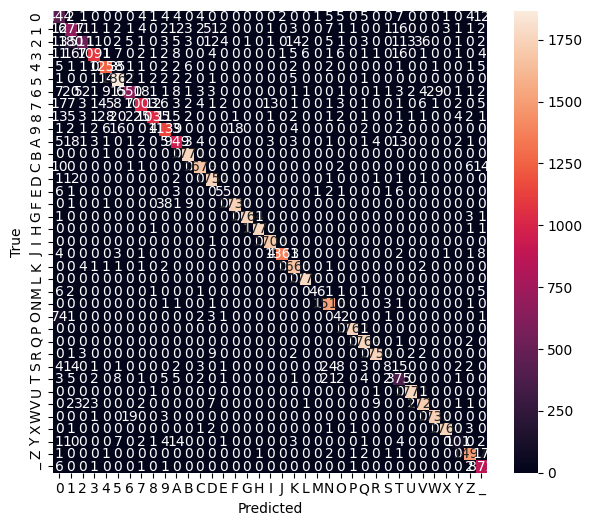

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.88      0.77       506
           1       0.69      0.83      0.75       818
           2       0.81      0.62      0.70       830
           3       0.97      0.91      0.94      1193
           4       0.92      0.95      0.93      1324
           5       0.94      0.98      0.96      1901
           6       0.94      0.78      0.85       836
           7       0.94      0.87      0.90      1155
           8       0.98      0.89      0.93      1168
           9       0.93      0.95      0.94      1200
          10       0.92      0.93      0.93      1020
          11       0.98      1.00      0.99      1772
          12       0.98      0.98      0.98      1713
          13       0.95      0.99      0.97      1773
          14       0.82      0.72      0.77        76
          15       0.99      0.97      0.98      1781
          16       1.00      1.00      1.00      1770
     

In [137]:
# Predict
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# Print the matrix
print_confusion_matrix(y_true, y_pred)

### Convert to TensorFlow Lite model (quantization)

In [138]:
tflite_save_path = '../model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpehkdgfu2/assets


INFO:tensorflow:Assets written to: /tmp/tmpehkdgfu2/assets


Saved artifact at '/tmp/tmpehkdgfu2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 37), dtype=tf.float32, name=None)
Captures:
  139549237592912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139549237603280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139549237599440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139549237600016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139549088348880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139549088346960: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1750310638.177856  105112 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750310638.177867  105112 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-19 00:23:58.177980: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpehkdgfu2
2025-06-19 00:23:58.178276: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-19 00:23:58.178282: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpehkdgfu2
2025-06-19 00:23:58.181153: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-06-19 00:23:58.199578: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpehkdgfu2
2025-06-19 00:23:58.204905: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 26926 microseconds.


21560

### Inference test for tflite model

Unlike `model.predict()` in standard TensorFlow, which is high-level and Python-friendly, TFLite uses a lower-level API via the Interpreter. full low-level inference pipeline 

- `allocate_tensors()`: Prepares memory and allocates input/output buffers
- `set_tensor()`: Loads input manually — no .predict() convenience
- `invoke()`: Explicitly triggers the model execution
- `get_tensor()`: Retrieves output from the model manually

In [139]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors() # Allocate memory for the interpreter

/home/thong/Desktop/hand-gesture-detection/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [140]:
# Obtain input and output tensors
# input_details: a list contains information about the input tensor, including its shape and data type.
# output_details: a list contains information about the output tensor, including its shape and data type.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("input_details:", input_details)
print("output_details:", output_details)

# Each of these returns a list of dictionaries with info like:
# - 'index': index used when setting or getting tensors
# - 'shape': expected shape (e.g., [1, 40])
# - 'dtype': expected data type (float32, int8, etc.)

input_details: [{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([ 1, 40], dtype=int32), 'shape_signature': array([-1, 40], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 10, 'shape': array([ 1, 37], dtype=int32), 'shape_signature': array([-1, 37], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [141]:
# input_details[0]: first input tensor
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [142]:
%%time
# Perform inference
interpreter.invoke() # Run the model on the input data
tflite_results = interpreter.get_tensor(output_details[0]['index']) # Get the output tensor

CPU times: user 35 μs, sys: 1e+03 ns, total: 36 μs
Wall time: 41.2 μs


In [143]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.8265757e-10 1.0843946e-03 6.3038856e-01 3.4871076e-03 1.0134437e-08
 7.7344171e-15 3.5229515e-02 1.7273154e-05 1.3789671e-06 1.8159063e-09
 4.5008903e-08 2.5964491e-26 2.8190564e-24 9.4333985e-11 6.9813166e-13
 1.1370219e-17 2.1037826e-12 4.7093812e-14 1.6060167e-17 8.8273076e-11
 2.6515769e-03 2.3882707e-24 4.3995291e-16 2.4280866e-11 7.1046114e-19
 5.3398068e-22 2.9719256e-37 3.9335143e-14 1.4119807e-10 3.9240038e-11
 2.0931914e-07 3.2713991e-01 8.0159729e-10 6.8122455e-18 3.5429721e-08
 6.8544259e-13 1.0018048e-16]
2
